## Part IV: Final model to predict price per m2
This part of the project shows the process of developing a model for determining the price per meter of real estate

### Preprocessing

In [294]:
# importing libraries
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
    PassiveAggressiveRegressor,
    HuberRegressor,
    TweedieRegressor,
    BayesianRidge,
    OrthogonalMatchingPursuit
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    IsolationForest,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from lazypredict.Supervised import LazyClassifier

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers

import plotly.express as px
import plotly.graph_objects as go

from typing import List
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

from modules.analytical_tools import regressor_models_comparison

In [295]:
df = pd.read_csv('data/wroclaw_dataset_ver_3.csv')
df.shape

(8507, 141)

In [296]:
df = df.dropna()

In [297]:
df.shape

(8507, 141)

### Checking the correlation strength of PRICE_PER_M2 and other parameters

In [298]:
# generating correlation matrix
corr = df.corr( )

# selecting only the BUILD_YEAR column and sorting the absolute values of the correlations in descending order
corr_with_price = corr['PRICE_PER_M2'].sort_values(key=lambda x: abs(x), ascending=False)

# creating a column with the absolute value of the correlation
corr_abs = abs(corr_with_price)

# creating a DataFrame with a correlation value and its absolute value
corr_df = pd.DataFrame({'Correlation': corr_with_price, 'Absolute Correlation': corr_abs})

# showing only parameters with significant correlation
corr_df[corr_df['Absolute Correlation'] >= 0.1]

,Correlation,Absolute Correlation
PRICE_PER_M2,1.00,1.00
DISTANCE_FROM_CITY_CENTER_KM,-0.42,0.42
AREA,-0.34,0.34
ROOMS_NUM_1,0.33,0.33
BUILDING_FLOORS_NUM,0.30,0.30
DISTRICT_Stare Miasto,0.27,0.27
PRICE,0.27,0.27
RESIDENTIAL_AREA_Stare Miasto,0.27,0.27
DISTRICT_Śródmieście,0.24,0.24
RESIDENTIAL_AREA_Ołbin,0.23,0.23


There is a noticeable moderate correlation with: DISTANCE_FROM_CITY_CENTER_KM, ROOMS_NUM_1, BUILDING_FLOORS_NUM and about 30 potential weak correlation with other parameters.<br><br>
Most of them are related to locations, but there are also correlation with:
* area
* number of rooms
* building type
* building material
* availability of an elevator in the building
* floor number

#### Correlations are easily seen on the heatmap

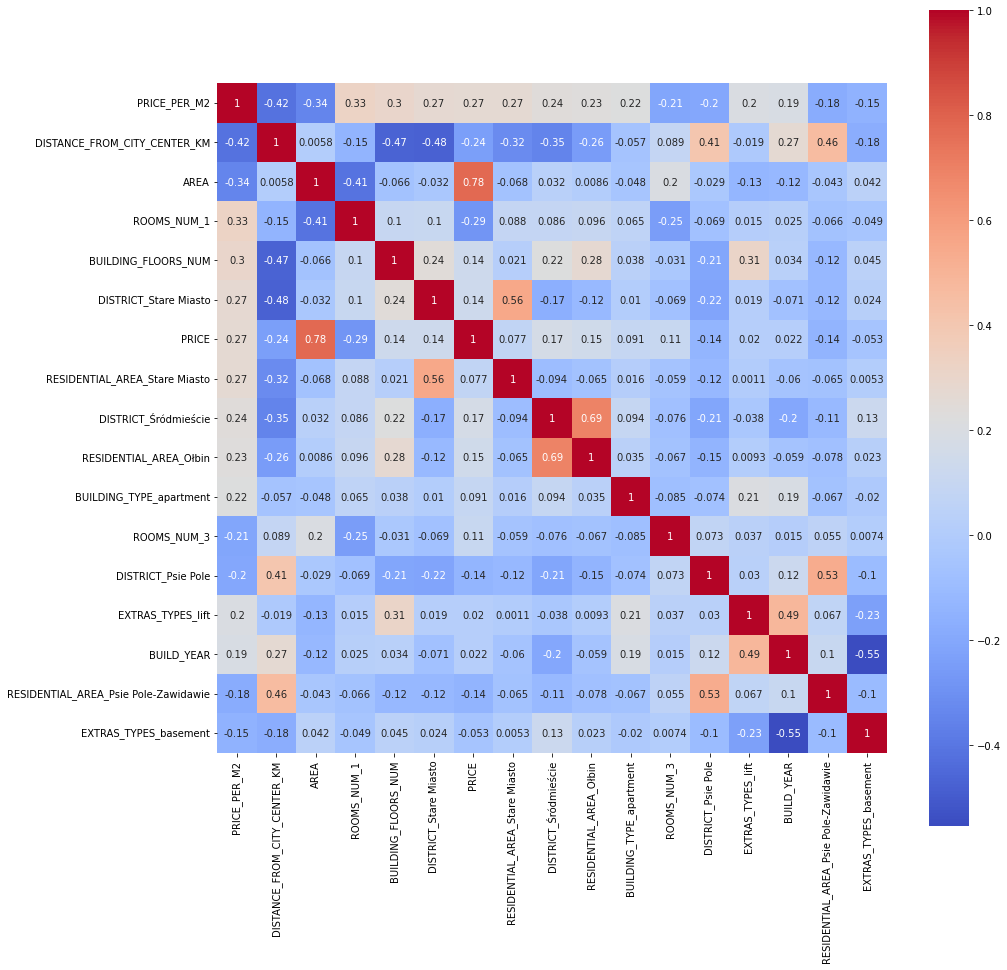

In [299]:
corr = df.corr()

# utworzenie DataFrame z wartością korelacji i jej wartością bezwzględną
corr_with_price = corr['PRICE_PER_M2'].sort_values(key=lambda x: abs(x), ascending=False)
corr_abs = abs(corr_with_price)
corr_df = pd.DataFrame({'Correlation': corr_with_price, 'Absolute Correlation': corr_abs})

# wybór kolumn z wartością bezwzględną korelacji powyżej 0.1
strong_corr = corr_df[corr_df['Absolute Correlation'] > 0.15]
strong_corr_columns = strong_corr.index.tolist()
df_filtered = df[strong_corr_columns]

plt.figure(figsize=(15,15))
# generowanie heatmapy dla wybranych kolumn
sns.heatmap(df_filtered.corr(), annot=True, cmap='coolwarm', square=1, )

# wyświetlenie heatmapy
plt.show()

### Building model to predict values

In [300]:
# splitting dataset to data and target

X = df.drop(columns=['PRICE_PER_M2', 'PRICE'])
y = df['PRICE_PER_M2']

In [301]:
# splitting data to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [302]:
# creating list of models to compare

models = [
    LinearRegression(),
    Ridge(alpha=0.1),
    Lasso(alpha=0.1),
    ElasticNet(alpha=0.1, l1_ratio=0.5),
    DecisionTreeRegressor(), 
    XGBRegressor(), 
    GradientBoostingRegressor(),
    AdaBoostRegressor(), 
    RandomForestRegressor(), 
    KNeighborsRegressor(n_neighbors=5),
    SVR(),
    MLPRegressor(),
    BayesianRidge(),
    PassiveAggressiveRegressor(),
    HuberRegressor(),
    TweedieRegressor(),
    GaussianProcessRegressor(),
    OrthogonalMatchingPursuit(),
    CatBoostRegressor(verbose=0),
    LGBMRegressor()
]



In [303]:
warnings.filterwarnings("ignore",)

results = regressor_models_comparison(X_train, X_test, y_train, y_test, models, verbose= True, round_prediction=0)

Successfully evaluated ( 1 / 20) : LinearRegression           -> MAE: 1078.98, R2: 0.60
Successfully evaluated ( 2 / 20) : Ridge                      -> MAE: 1078.87, R2: 0.60
Successfully evaluated ( 3 / 20) : Lasso                      -> MAE: 1077.98, R2: 0.60
Successfully evaluated ( 4 / 20) : ElasticNet                 -> MAE: 1154.70, R2: 0.55
Successfully evaluated ( 5 / 20) : DecisionTreeRegressor      -> MAE: 799.80, R2: 0.64
Successfully evaluated ( 6 / 20) : XGBRegressor               -> MAE: 686.32, R2: 0.80
Successfully evaluated ( 7 / 20) : GradientBoostingRegressor  -> MAE: 880.69, R2: 0.71
Successfully evaluated ( 8 / 20) : AdaBoostRegressor          -> MAE: 1706.61, R2: 0.23
Successfully evaluated ( 9 / 20) : RandomForestRegressor      -> MAE: 616.66, R2: 0.82
Successfully evaluated (10 / 20) : KNeighborsRegressor        -> MAE: 831.90, R2: 0.70
Successfully evaluated (11 / 20) : SVR                        -> MAE: 1735.31, R2: -0.03
Successfully evaluated (12 / 20) : M

In [304]:
# creating pivot table to check mean values of each model and metrics

results_pivot_table = pd.pivot_table(results, index='Model',
                             values=['MSE', 'RMSE', 'MAE', 'R2'],
                             aggfunc=np.mean)

results_pivot_table = results_pivot_table.sort_values('R2', ascending=False)
results_pivot_table

,MAE,MSE,R2,RMSE
Model,,,,
RandomForestRegressor,616.66,964142.14,0.82,981.91
CatBoostRegressor,680.86,983415.15,0.82,991.67
XGBRegressor,686.32,1059912.85,0.80,1029.52
LGBMRegressor,721.85,1123381.27,0.79,1059.90
GradientBoostingRegressor,880.69,1554375.80,0.71,1246.75
KNeighborsRegressor,831.90,1627341.25,0.70,1275.67
DecisionTreeRegressor,799.80,1922077.19,0.64,1386.39
Lasso,1077.98,2169989.01,0.60,1473.09
BayesianRidge,1077.39,2170831.33,0.60,1473.37


The metrics suggest that the model with the best quality is:<b>
* RandomForestRegressor 
</b>

R2 values oscillate around the value of 0.82, which means vry good fit to the data. There are more models with so high R2, but they have more MAE then RandomForestRegressor.

Next, it will be checked how removing outliers and standardization will affect the metrics

### Removing outliers from continous columns

In [305]:
# preparing list of continuous columns

continuous_cols = []
for col in X.columns:
    if set(X[col].unique()) != {0, 1}:
        continuous_cols.append(col)


In [306]:
total_num_of_outliers = 0

df_clean = df.copy()

for column in continuous_cols:

    start_num_samples = df_clean.shape[0]
    
    # removing outliers with IQR method

    Q1 = df_clean[column].quantile(0.25)
    Q3 = df_clean[column].quantile(0.75)
    IQR = Q3 - Q1

    df_clean = df_clean[(df_clean[column] > (Q1 - 3 * IQR)) & (df_clean[column] < (Q3 + 3 * IQR))]


    num_removed = start_num_samples - df_clean.shape[0]
    total_num_of_outliers += num_removed
  
    print(f'Removed {num_removed} samples from column: {column}')


print(f'\nRemoved {total_num_of_outliers} outliers')
print(f"Number of remaining samples: {df_clean.shape[0]}")

Removed 35 samples from column: AREA
Removed 793 samples from column: BUILD_YEAR
Removed 140 samples from column: BUILDING_FLOORS_NUM
Removed 0 samples from column: DISTANCE_FROM_CITY_CENTER_KM

Removed 968 outliers
Number of remaining samples: 7539


Repeat the previous steps to compare the results with cleaned data

In [307]:
# splitting dataset to data and target

X = df_clean.drop(columns=['PRICE_PER_M2', 'PRICE'])
y = df_clean['PRICE_PER_M2']

# splitting data to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [308]:

# scaling continuous columns
scaler = StandardScaler()

# Fit scaler only on training data
scaler.fit(X_train[continuous_cols])

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[continuous_cols] = scaler.transform(X_train[continuous_cols])
X_test_scaled[continuous_cols] = scaler.transform(X_test[continuous_cols])


In [309]:
# evaluating models
clean_scaled_results = regressor_models_comparison(X_train_scaled, X_test_scaled, y_train, y_test, models, verbose= True, round_prediction=0)

Successfully evaluated ( 1 / 20) : LinearRegression           -> MAE: 994.88, R2: 0.63
Successfully evaluated ( 2 / 20) : Ridge                      -> MAE: 994.79, R2: 0.63
Successfully evaluated ( 3 / 20) : Lasso                      -> MAE: 994.86, R2: 0.63
Successfully evaluated ( 4 / 20) : ElasticNet                 -> MAE: 1070.56, R2: 0.58
Successfully evaluated ( 5 / 20) : DecisionTreeRegressor      -> MAE: 773.31, R2: 0.64
Successfully evaluated ( 6 / 20) : XGBRegressor               -> MAE: 639.42, R2: 0.82
Successfully evaluated ( 7 / 20) : GradientBoostingRegressor  -> MAE: 825.05, R2: 0.73
Successfully evaluated ( 8 / 20) : AdaBoostRegressor          -> MAE: 1655.30, R2: 0.27
Successfully evaluated ( 9 / 20) : RandomForestRegressor      -> MAE: 580.22, R2: 0.83
Successfully evaluated (10 / 20) : KNeighborsRegressor        -> MAE: 779.50, R2: 0.73
Successfully evaluated (11 / 20) : SVR                        -> MAE: 1650.57, R2: 0.02
Successfully evaluated (12 / 20) : MLPRe

### Results analysis

In [310]:
# creating pivot table to check scaled metrics 

clean_scaled_results_pivot_table = pd.pivot_table(clean_scaled_results, index='Model',
                             values=['MSE', 'RMSE', 'MAE', 'R2'],
                             aggfunc=np.mean)



clean_scaled_results_pivot_table = clean_scaled_results_pivot_table.sort_values('R2', ascending=False)

# creating pivot tables to check comparison
results_combinded = pd.concat([results_pivot_table, clean_scaled_results_pivot_table.add_prefix('new_')], axis=1)

# modyfiing and adding values
results_combinded = results_combinded.rename(columns={'MAE': 'old_MAE' , 'R2': 'old_R2'} )
# results_combinded = results_combinded.rename(columns={'MAE': 'MAE_old', 'R2': 'old_R2'})

results_combinded['diff_MAE'] =  results_combinded['new_MAE'] - results_combinded['old_MAE']
results_combinded['diff_R2'] =  results_combinded['new_R2'] - results_combinded['old_R2']

results_combinded = results_combinded[["old_MAE", "new_MAE",'diff_MAE',  "old_R2", "new_R2", "diff_R2"]]
results_combinded.sort_values('new_MAE', ascending=1)

,old_MAE,new_MAE,diff_MAE,old_R2,new_R2,diff_R2
Model,,,,,,
RandomForestRegressor,616.66,580.22,-36.44,0.82,0.83,0.01
XGBRegressor,686.32,639.42,-46.90,0.80,0.82,0.01
CatBoostRegressor,680.86,647.15,-33.71,0.82,0.82,0.00
LGBMRegressor,721.85,690.39,-31.46,0.79,0.80,0.01
DecisionTreeRegressor,799.80,773.31,-26.50,0.64,0.64,-0.00
KNeighborsRegressor,831.90,779.50,-52.40,0.70,0.73,0.04
GradientBoostingRegressor,880.69,825.05,-55.64,0.71,0.73,0.02
HuberRegressor,1169.77,967.87,-201.89,0.52,0.62,0.10
PassiveAggressiveRegressor,2283.48,989.89,-1293.58,-0.61,0.61,1.22


Removing outliers and standarisation slightly improved results of most of the models, both R2 and MAE<br><br>
The Random Forest model still has the best metrics, only this model has MAE less than 600


### Visualisaton of best models

In [ ]:
best_models = [
    RandomForestRegressor(random_state=42), 
    XGBRegressor(random_state=42),
    CatBoostRegressor(verbose=0, random_state=42)]

Unscaled data:

In [361]:
warnings.filterwarnings("ignore",)
unscaled_results = regressor_models_comparison(X_train, X_test, y_train, y_test, best_models, verbose= True, visualize_fit= False, visualize_resid= True, round_prediction=0)

Successfully evaluated ( 1 / 3) : RandomForestRegressor -> MAE: 575.98, R2: 0.83
Successfully evaluated ( 2 / 3) : XGBRegressor          -> MAE: 639.42, R2: 0.82
Successfully evaluated ( 3 / 3) : CatBoostRegressor     -> MAE: 644.65, R2: 0.82


Scaled data:

In [363]:
warnings.filterwarnings("ignore",)
clean_scaled_results = regressor_models_comparison(X_train_scaled, X_test_scaled, y_train, y_test, best_models, verbose= True, visualize_fit= False, visualize_resid= True, round_prediction=0)

Successfully evaluated ( 1 / 3) : RandomForestRegressor -> MAE: 576.14, R2: 0.83
Successfully evaluated ( 2 / 3) : XGBRegressor          -> MAE: 639.42, R2: 0.82
Successfully evaluated ( 3 / 3) : CatBoostRegressor     -> MAE: 644.67, R2: 0.82


Conclusions from visualisation:<br>
* Model works quite correct with prices for m2 in most common ranges: 8 - 12 k per m2
* Predicting more expenive offers is much less accurate
* This is probably due to the different specificity of more expensive offers that may be intended for premium customers or investors

<br>
From all of the models the as the one to futher work will be<b> Random Forest </b>, due to:

1. the best metrics from all of the models
2. almost identical metrics and prediction on scaled and unscaled verion of data
3. this means that this model will be the easiest to implement


Model will be compared with Neutral Network to check if this model work better with unusual offers

### Neutral Network

In [364]:
# building Random Foreest Model
rf_model = RandomForestRegressor(random_state=42, verbose=0, )
rf_model.fit(X_train, y_train)

# prediction nd metrics
y_pred_rf = rf_model.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print("CatBoost - R2: {:.2f}, MAE: {:.2f}".format(r2_rf, mae_rf))

CatBoost - R2: 0.82, MAE: 575.99


In [379]:
from keras.callbacks import EarlyStopping, ModelCheckpoint


# creating neutral network
nn_model = Sequential()
nn_model.add(Dense(64, activation='relu', kernel_regularizer='l2', input_shape=(len(X.keys()),)))
# nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(16, activation='relu'))
nn_model.add(Dense(1, activation='linear'))
opt = optimizers.Adam(learning_rate=0.001)
nn_model.compile(optimizer=opt, loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint('models/nn_price_per_m2_best_model.h5', monitor='val_loss', save_best_only=True, mode='min')

nn_model_history = nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test), callbacks=[early_stop, checkpoint])

# predictions and calculation of metrics
y_pred_nn = nn_model.predict(X_test_scaled)
r2_nn = r2_score(y_test, y_pred_nn)
mae_nn = mean_absolute_error(y_test, y_pred_nn)


# calculating residuals
residuals_rf = y_test - y_pred_rf
residuals_nn = y_test - y_pred_nn.flatten()

# creating residual plot
trace_cb = go.Scatter(x=y_pred_rf, y=residuals_rf,
                      mode='markers', name='Random Forest')
trace_nn = go.Scatter(x=y_pred_nn.flatten(), y=residuals_nn,
                      mode='markers', name='Neutral Network')
trace_zero = go.Scatter(x=[min(y_test), max(y_test)],
                        y=[0, 0], mode='lines', name='0 line')
layout = go.Layout(title=dict(text='Residual plot', x=0.5),
                   xaxis=dict(title='y_pred'),
                   yaxis=dict(title='residual'))


fig = go.Figure(data=[trace_cb, trace_nn, trace_zero], layout=layout)


fig.show()

print("Random Forest - R2: {:.2f}, MAE: {:.2f}".format(r2_rf, mae_rf))
print("Neural Network - R2: {:.2f}, MAE: {:.2f}".format(r2_nn, mae_nn))


Epoch 1/100
189/189 [==============================] - 2s 4ms/step - loss: 125809824.0000 - mae: 10974.9424 - val_loss: 123170024.0000 - val_mae: 10856.7119
Epoch 2/100
189/189 [==============================] - 1s 3ms/step - loss: 110607520.0000 - mae: 10252.5859 - val_loss: 92720448.0000 - val_mae: 9356.5811
Epoch 3/100
189/189 [==============================] - 1s 5ms/step - loss: 65724036.0000 - mae: 7713.8491 - val_loss: 38720388.0000 - val_mae: 5801.6191
Epoch 4/100
189/189 [==============================] - 0s 2ms/step - loss: 20232566.0000 - mae: 3797.1819 - val_loss: 8912052.0000 - val_mae: 2240.8577
Epoch 5/100
189/189 [==============================] - 0s 2ms/step - loss: 6036769.0000 - mae: 1785.6279 - val_loss: 5162251.0000 - val_mae: 1640.8092
Epoch 6/100
189/189 [==============================] - 0s 2ms/step - loss: 4666052.5000 - mae: 1602.1509 - val_loss: 4635921.5000 - val_mae: 1588.0186
Epoch 7/100
189/189 [==============================] - 0s 2ms/step - loss: 425914

Random Forest - R2: 0.83, MAE: 575.99
Neural Network - R2: 0.67, MAE: 931.34


### Conclusions

Neutral Network has the same pros and cons as Random Forest. Both are good in predicting standard offers, but the most expensive ones are problematic <br>

This problem is not very important from the point of view of the project assumptions, becouse main goal is finding  offers with potentially bargain prices.

<b>Finally, the Random Forest model will be selected for prediction due to:</b> high quality of predictions based on unscaled data.

This will make simply to combine predictions of missing build years and final prices without additional dataframe manipulations.

Model with the best hyperparameters will by find using searchGrid and saved to futher work.



In [382]:
# trenowanie modelu
rf_model = RandomForestRegressor(n_estimators=500, random_state=42)
rf_model.fit(X_train, y_train)

# predykcja na danych testowych
y_pred = rf_model.predict(X_test)

# obliczanie metryk
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# wyświetlanie metryk
print("R2: {:.2f}".format(r2))
print("MAE: {:.2f}".format(mae))

# tworzenie wykresu resztowego
residuals = y_test - y_pred

rf_fig = px.scatter(x=y_pred, y=residuals, labels={'x':'y_pred', 'y':'residual'})

rf_fig.add_shape(type='line',
              x0=y_pred.min(), x1=y_pred.max(),
              y0=0, y1=0,
              line=dict(color='red', width=3, dash='dash'))

rf_fig.update_traces(texttemplate='%{y:.2f}', textposition='top center', hovertemplate='Predicted price per m2: %{x:.2f} <br> residual: %{y:.2f}')

rf_fig.update_layout(
    title='Random Forest Residual Plot',
    xaxis_title='y_pred',
    yaxis_title='Residual',
    title_x=0.5
)

rf_fig.show()

R2: 0.83
MAE: 575.34


In [386]:
# saving model
joblib.dump(rf_model, 'models/rf_price_per_m2_prediction.pkl')


['models/rf_price_per_m2_prediction.pkl']